In [4]:
import json
# Calculate classifier calibration
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import pandas as pd
import seaborn as sns
import numpy as np


data_filename = "../data/llava-1.5_with_image.json"
data = json.load(open(data_filename, "r"))
data

[{'question_id': '114',
  'question': 'What brand is the red truck? Choices: dodge, chevy, ford, toyota',
  'predicted_answer': 'Dodge',
  'prediction_is_correct': 1,
  'generated_rationale': "The reasoning behind my answer is that the red truck is a Dodge Ram, which is a type of pickup truck. Dodge Ram is a well-known brand of pickup trucks, and the red color of the truck in the image is consistent with the typical color of a Dodge Ram pickup truck. The other options, Chevy, Ford, and Toyota, are also well-known brands of pickup trucks, but they do not match the image's description of a red Dodge Ram pickup truck.",
  'visual_fidelity': 1.0,
  'contrastiveness': 0.998734960620666},
 {'question_id': '348',
  'question': 'Where are the sheep located? Choices: farm, street, mountain, park',
  'predicted_answer': 'Street',
  'prediction_is_correct': 1,
  'generated_rationale': 'The reasoning behind my answer is that the image shows a herd of sheep crossing a street, which is an unusual lo

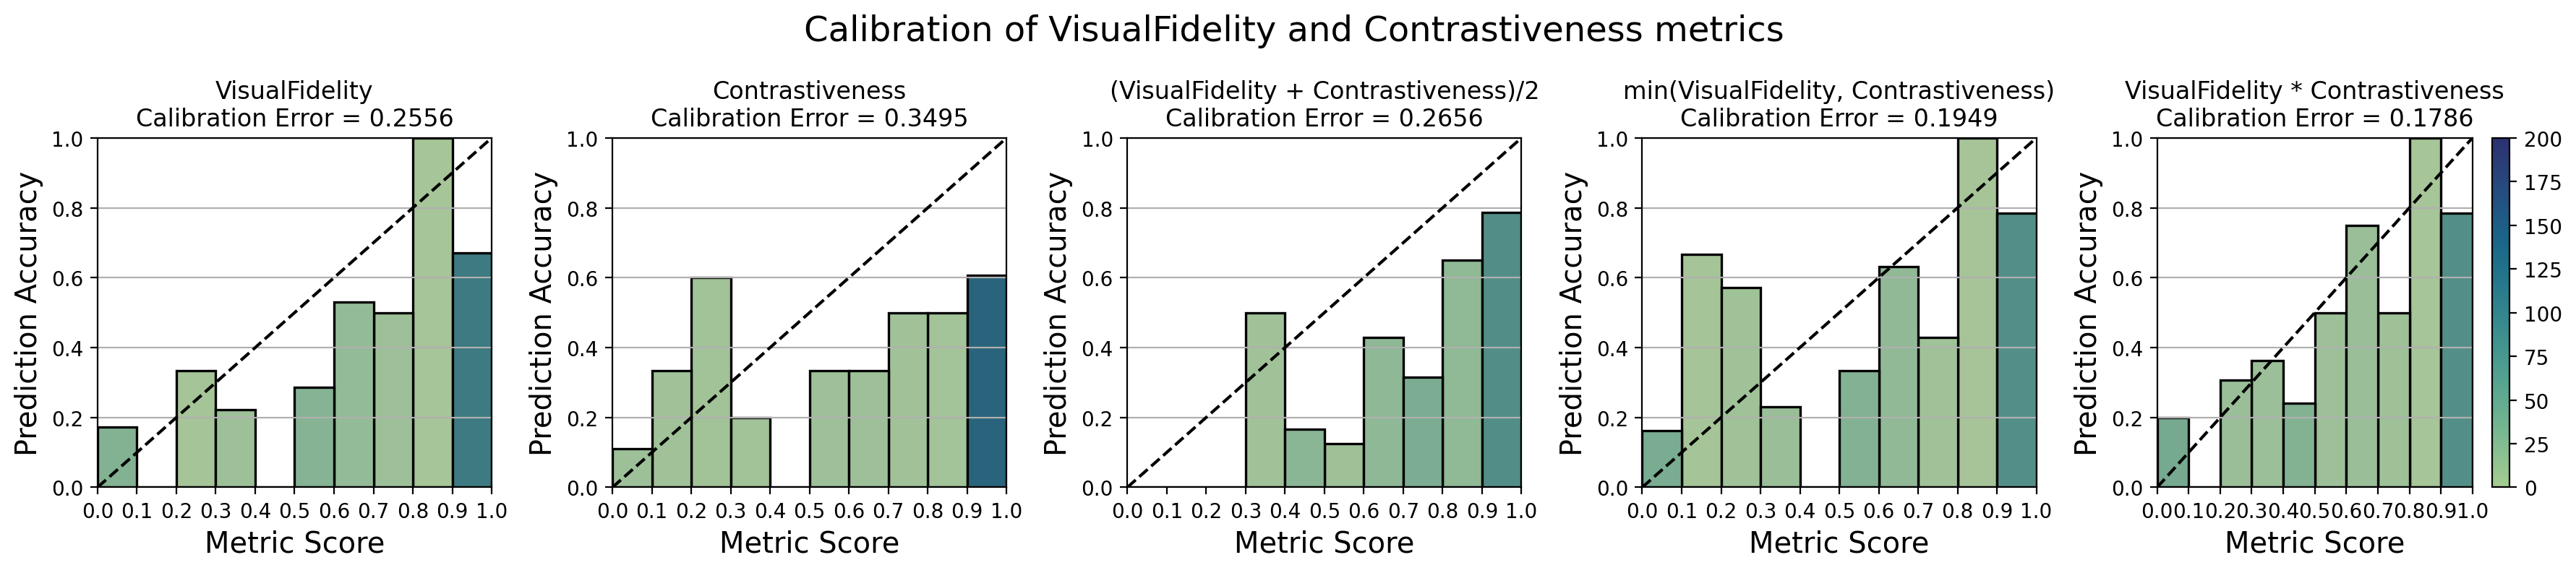

In [3]:
visual_fidelities = np.array([x['visual_fidelity'] for x in data])
contrastiveness_scores = np.array([x['contrastiveness'] for x in data])
correctnesses = np.array([x['prediction_is_correct'] for x in data])



def plot_calibration_curve(y_true, y_prob, ax, title):
    bin_num_positives, bin_mean_probs, bin_num_instances, bin_centers = [], [], [], []
    for i in range(10):
        bin_lower = i/10
        bin_upper = (i+1)/10 if i != 9 else 1.01
        bin_indices = [j for j in range(len(y_prob)) if bin_lower <= y_prob[j] < bin_upper]
        if len(bin_indices) != 0:
            bin_num_positives.append(np.mean(y_true[bin_indices]))
            bin_mean_probs.append(np.mean(y_prob[bin_indices]))
            bin_num_instances.append(len(bin_indices))
            bin_centers.append((i+0.5)/10)
        else:
            bin_num_positives.append(0)
            bin_mean_probs.append(0)
            bin_num_instances.append(0)
            bin_centers.append((i+0.5)/10)

    # Calculate expected calibration error
    ece = 0
    for i in range(len(bin_num_positives)):
        ece += bin_num_instances[i] * np.abs(bin_num_positives[i] - bin_mean_probs[i])
    ece /= sum(bin_num_instances)

    #print(bin_num_positives, bin_mean_probs, bin_num_instances)
    df = pd.DataFrame({'bin_num_positives': bin_num_positives, 'bin_centers': bin_centers, 'bin_num_instances': bin_num_instances})
    sns.barplot(x='bin_centers', y='bin_num_positives', data=df, ax=ax, hue='bin_num_instances', palette='crest', edgecolor='black', linewidth=1.2, width=1, hue_norm=(0, 200))
    ax.grid(axis='y')
    ax.plot([-0.5, 9.5], [0, 1], "k--")
    #ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    ax.set_xlim(-0.5, 9.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Metric Score", fontsize='x-large')
    ax.set_ylabel("Prediction Accuracy", fontsize='x-large')
    ax.set_title(f"{title}\nCalibration Error = {ece:.4f}", fontsize='large')
    ax.set_xticks(np.arange(-0.5, 10.5, 1))
    ax.set_xticklabels([i/10 for i in range(11)])
    
    ax.legend().remove()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(18, 4), dpi=200)
fig.suptitle("Calibration of VisualFidelity and Contrastiveness metrics", fontsize='xx-large')
plot_calibration_curve(correctnesses, visual_fidelities, ax[0], "VisualFidelity")
plot_calibration_curve(correctnesses, contrastiveness_scores, ax[1], "Contrastiveness")
plot_calibration_curve(correctnesses, np.array([(x+y)/2 for x, y in zip(visual_fidelities, contrastiveness_scores)]), ax[2], "(VisualFidelity + Contrastiveness)/2")
plot_calibration_curve(correctnesses, np.array([min(x, y) for x, y in zip(visual_fidelities, contrastiveness_scores)]), ax[3], "min(VisualFidelity, Contrastiveness)")
plot_calibration_curve(correctnesses, np.array([x*y for x, y in zip(visual_fidelities, contrastiveness_scores)]), ax[4], "VisualFidelity * Contrastiveness")

norm = plt.Normalize(0, 200)
sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
ax[4].figure.colorbar(sm, ax=ax[4])

fig.tight_layout()
plt.show()


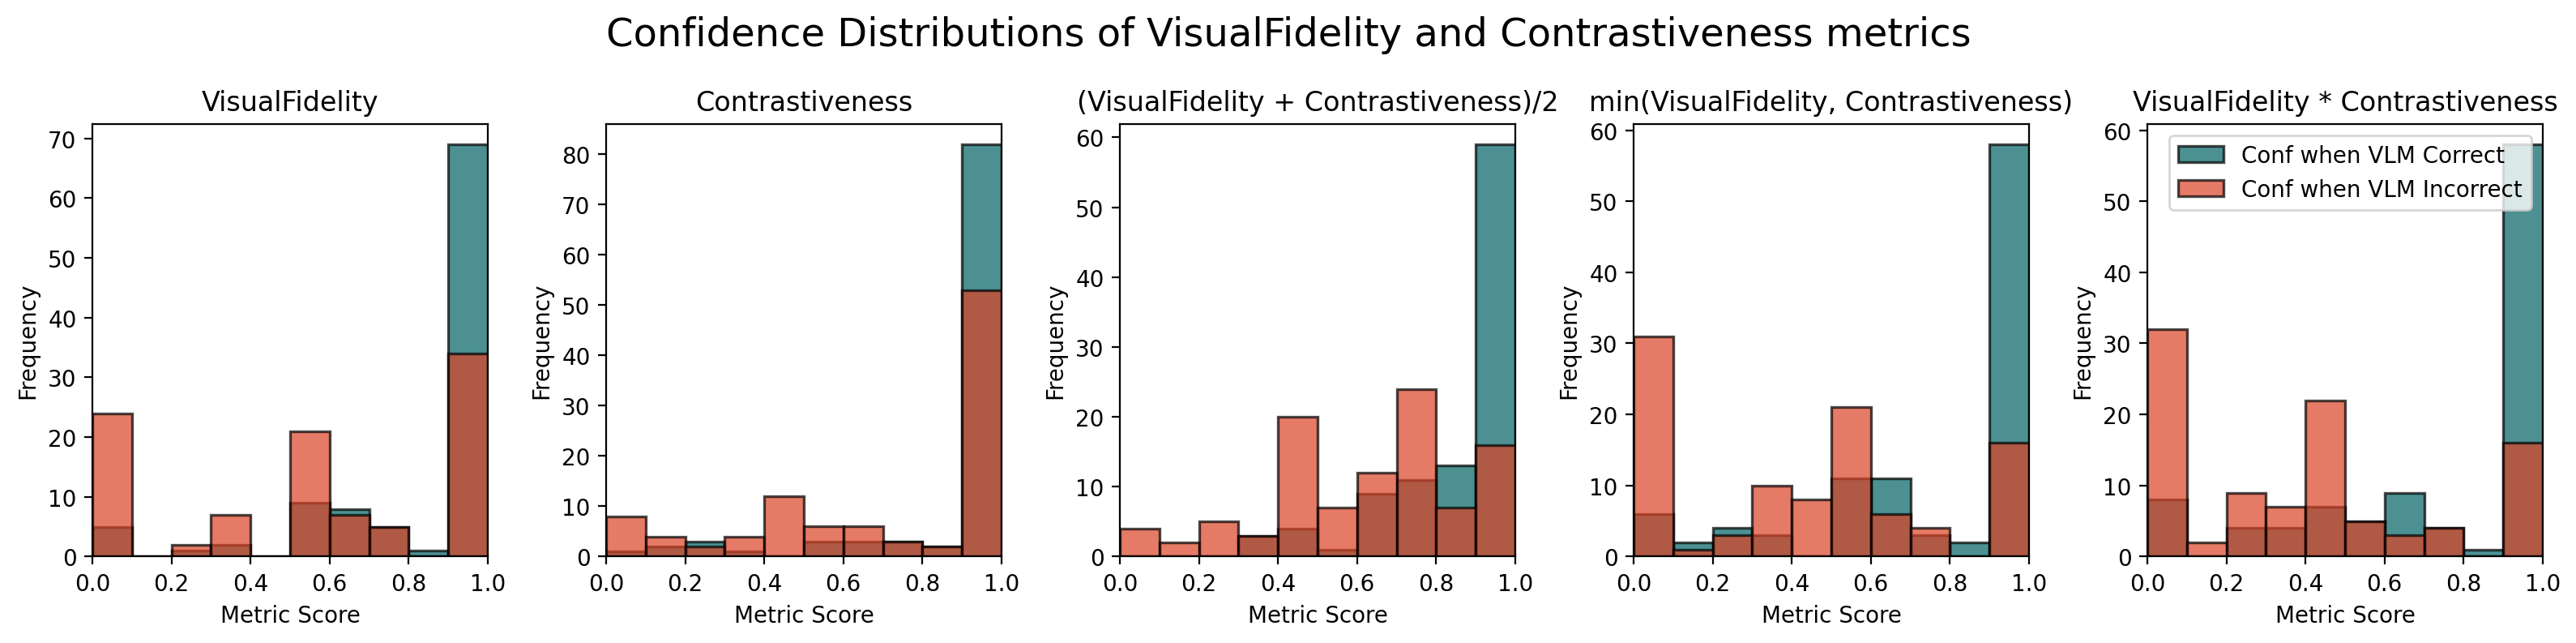

In [27]:
def plot_confidence_distributions(y_true, y_prob, title, ax):
    y_prob_when_correct = y_prob[y_true == 1]
    y_prob_when_incorrect = y_prob[y_true == 0]
    ax.hist(y_prob_when_correct, bins=10, range=(0, 1), color='#006164', edgecolor='black', linewidth=1.2, histtype='bar', density=False, alpha=0.7)
    ax.hist(y_prob_when_incorrect, bins=10, range=(0, 1), color='#db4325', edgecolor='black', linewidth=1.2, histtype='bar', density=False, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Metric Score")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, 1)

fig, ax = plt.subplots(1, 5, figsize=(16, 4), dpi=200)
fig.suptitle("Confidence Distributions of VisualFidelity and Contrastiveness metrics", fontsize='xx-large')
plot_confidence_distributions(correctnesses, visual_fidelities, "VisualFidelity", ax[0])
plot_confidence_distributions(correctnesses, contrastiveness_scores, "Contrastiveness", ax[1])
plot_confidence_distributions(correctnesses, np.array([(x+y)/2 for x, y in zip(visual_fidelities, contrastiveness_scores)]), "(VisualFidelity + Contrastiveness)/2", ax[2])
plot_confidence_distributions(correctnesses, np.array([min(x, y) for x, y in zip(visual_fidelities, contrastiveness_scores)]), "min(VisualFidelity, Contrastiveness)", ax[3])
plot_confidence_distributions(correctnesses, np.array([x*y for x, y in zip(visual_fidelities, contrastiveness_scores)]), "VisualFidelity * Contrastiveness", ax[4])

ax[4].legend(["Conf when VLM Correct", "Conf when VLM Incorrect"])
fig.tight_layout()
plt.show()

In [20]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])